### Imports

In [1]:
import numpy as np
import scipy.stats as ss
import math, itertools
import random
import time
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp as OR
from gurobipy import *

### Generation Methods

In [2]:
def discrete_beta_rand(mean):
    """Sample from a discretized gaussian distribution truncated to [lb,ub]."""
    a = 2.5
    b = 10
    m = a/(a+b)
    lb=1
    ub=(round(mean/m))+1
    x = np.arange(lb,ub+1)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.beta.cdf(xU, a,b,0,ub-lb) - ss.beta.cdf(xL, a,b,0,ub-lb)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    return np.random.choice(x, p = prob)

In [3]:
def perfect_bin_packing(mean,binCount,capacity):
    """Create a perfect bin packing input. Output problem instance and solution."""
    TYPES = []  # set of item types (volumes)
    count = {}  # count of each item type
    BINS = range(binCount) # set of bins
    pack = {}  # encodes optimal solution
    for b in BINS:
        pack.update({b:[]})
    for b in BINS:
        PPB = discrete_beta_rand(mean)  # pieces in this bin
        pos = list(range(1,capacity))  # list of positions
        split = random.sample(pos,PPB-1)  # split up capacity 
        split = sorted(split) # sort
        split.append(capacity)
        lastPos = 0
        for i in split:
            item = i - lastPos
            if item in TYPES:
                count[item] += 1
            else:
                TYPES.append(item)
                count.update({item : 1})
            pack[b].append(item)
            lastPos = i       
    return TYPES, count, pack

### Model

In [4]:
def bin_packing(TYPES,count,capacity,solver,timeLimit=None,relativeGap=None,integer=True):
    """Model for a bin packing problem."""
    
    BINS = list(range(sum(count.values()))) # upper bound for bins
    PAIRS = list(itertools.product(TYPES, BINS))
     
    # define model
    m = OR.Solver('packBins', solver)
    param = OR.MPSolverParameters()
    if timeLimit is not None:
        print(m.SetSolverSpecificParametersAsString('''TimeLimit %d \n 
                                                       NodeLimit 100 \n
                                                       MIPGap 0.05''' % timeLimit))
    if relativeGap is not None:
        param.SetDoubleParam(param.RELATIVE_MIP_GAP, relativeGap)
    
    ## CHANGE TO IntVar() FOR IP AND NumVar() FOR LP RELAXATION
    
    # decision variables
    x = {} # number of item type i placed in bin j
    for i,j in PAIRS:
        if integer:
            x[i,j] = m.IntVar(0, m.infinity(), ('(%s, %s)' % (i,j)))
        else:
            x[i,j] = m.NumVar(0, m.infinity(), ('(%s, %s)' % (i,j)))
    y = {} # 1 if bin i is used; 0 otherwise
    for i in BINS:
        if integer:
            y[i] = m.IntVar(0, 1, ('%s' % (i)))
        else:
            y[i] = m.NumVar(0, 1, ('%s' % (i)))
        
        
    # objective function
    m.Minimize(sum(y[i] for i in BINS)) # set objective
    
    # subject to: bin capacity
    for j in BINS:
        m.Add(sum(x[i,j]*i for i in TYPES) <= capacity)
        
    # subject to: all items packed
    for i in TYPES:
        m.Add(sum(x[i,j] for j in BINS) == count[i])
        
    # subject to: bin used or not
    for j in BINS:
        M = capacity
        m.Add(sum(x[i,j]*i for i in TYPES) <= M*y[j])
    
    m.Solve(param)
    
    # abs(best_bound - incumbent) / abs(incumbent) [Gurobi]
    incumbent = m.Objective().Value()
    best_bound = m.Objective().BestBound()
    if not incumbent == 0:
        gap = abs(best_bound - incumbent) / abs(incumbent)
    else:
        gap = -1
    return m.Objective().Value(), m.NumVariables(), m.NumConstraints()

### Tests Methods

In [5]:
def single_test(mean,binCount,capacity,solver,integer=True):
    s = time.time()
    TYPES, count, pack = perfect_bin_packing(mean,binCount,capacity)
    opt, var, con = bin_packing(TYPES,count,capacity,solver,integer=integer)
    f = time.time()
    return f-s, opt, var, con

In [6]:
def full_test(mean, bin_counts, capacities, solver, integer=True):
    results = {}
    for binCount in bin_counts:
        for capacity in capacities:
            t, opt, var, con= single_test(mean,binCount,capacity,solver,integer=integer)
            assert round(opt) == binCount
            results[(binCount,capacity,var,con)] = t
    return results

### Plotting Methods

In [7]:
def ppb_histo(pack):
    """show histogram of PPB (Pieces Per Bin)."""
    PPB = [] 
    for b in pack.keys():
        PPB.append(len(pack[b]))
    plt.hist(PPB,
         bins=max(PPB)-min(PPB),
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)
    plt.xlabel('Pieces Per Bin')
    plt.ylabel('Number of Bins')
    plt.title('Histogram of Pieces Per Bin')
    plt.show()

In [8]:
def volume_histo(ITEMS):
    """show histogram of item volumes."""
    plt.hist(ITEMS,
         bins=max(ITEMS)-min(ITEMS),
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)
    plt.xlabel('Item Volume')
    plt.ylabel('Number of Items')
    plt.title('Histogram of Item Volumes')
    plt.show()

In [9]:
def plot_results(results,x,y):    
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection='3d')
    xdata = []
    ydata = []
    zdata = []
    for i in results.keys():
        xdata.append(i[x])
        ydata.append(i[y])
        zdata.append(results[i])
    ax.scatter3D(xdata, ydata, zdata, cmap='Greens');
    
    lbl = {0:'# of Bins',
           1:'Bin Capacity',
           2:'# of Variables',
           3:'# of Constraints'}
    
    ax.set_xlabel(lbl[x])
    ax.set_ylabel(lbl[y])
    ax.set_zlabel('Run time (s)')
    ax.view_init(20, -80)

### Run Tests

In [10]:
# -------------------------------------------
# Historical Run:
# [5,10,15,20,25,30,40,50,75,100,125,150,200]
# [100,150,200,250,300]
# -------------------------------------------

# -------------------------------
# UNCOMMENT BELOW TO ROTATE PLOTS 
# %matplotlib notebook 
# -------------------------------

In [11]:
# SOLVERS
GUROBI = OR.Solver.GUROBI_MIXED_INTEGER_PROGRAMMING
CBC = OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING

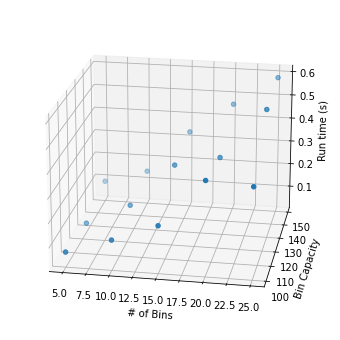

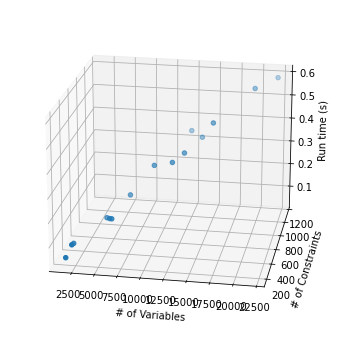

In [12]:
# GUROBI LP-RELAXATION
results = full_test(20, [5,10,15,20,25], [100,125,150], GUROBI, integer=False)
plot_results(results,0,1)
plot_results(results,2,3)

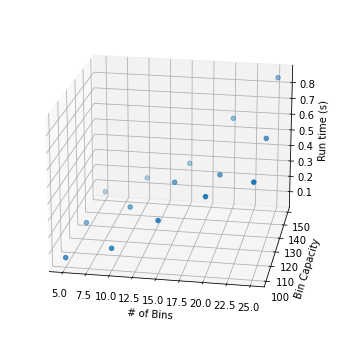

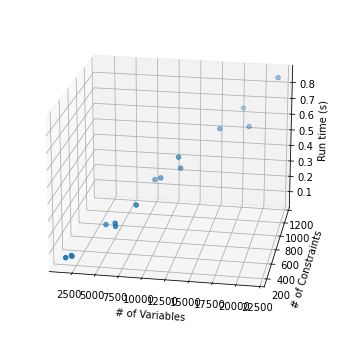

In [13]:
# CBC LP-RELAXATION
results = full_test(20, [5,10,15,20,25], [100,125,150], CBC, integer=False)
plot_results(results,0,1)
plot_results(results,2,3)

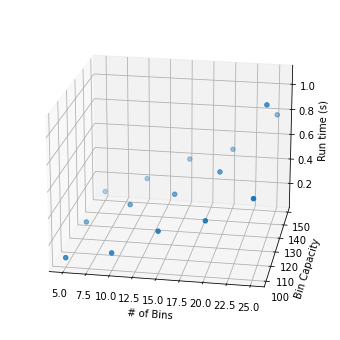

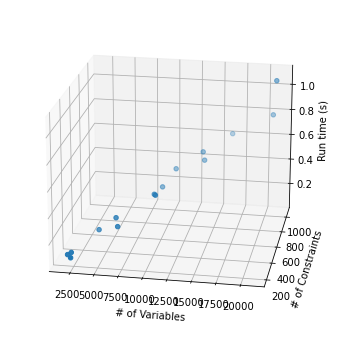

In [14]:
# GUROBI
results = full_test(20, [5,10,15,20,25], [100,125,150], GUROBI, integer=True)
plot_results(results,0,1)
plot_results(results,2,3)

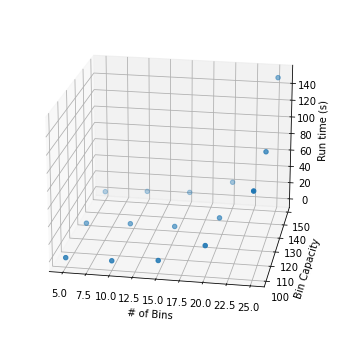

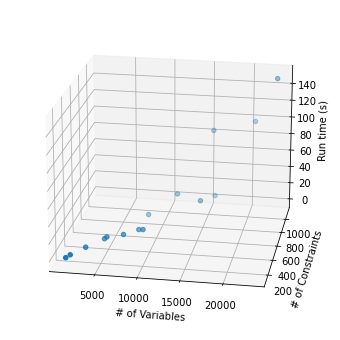

In [15]:
# CBC
results = full_test(20, [5,10,15,20,25], [100,125,150], CBC, integer=True)
plot_results(results,0,1)
plot_results(results,2,3)